In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
%matplotlib inline
from qiskit import Aer
from qiskit import execute
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer
from qiskit import IBMQ
from qiskit import compile
from qiskit.tools.visualization import plot_histogram

my_style = {'cregbundle': True}

In this notebook, we will try to implement Shor's algorithm for a simple example using Qiskit. Shor's algorithm applies to composite numbers M which are odd and not a prime power. So the smallest meaningful example is M=15.

In our implementation, we will actually cheat - we will use knowledge about the factors of M at some points that we would not have for a real example with a large integer M. 

To start, let us recall that the algorithm picks a number a relatively prime to M and calculates the period of a module M. We will use a = 7. Let us manually determine its period first.

In [2]:
M = 15
a = 7
print("a**2: ", a*a % M)
print("A**3: ", a**3 % M)
print("A**4: ", a**4 % M)


a**2:  4
A**3:  13
A**4:  1


Thus the period r is four. How would we find the period using a quantum circuit? For our implementation, it turns out to be most useful to describe Shor's algorithm in terms of the quantum phase estimation. In this description, we apply the quantum phase estimation algorithm to the state $|1 \rangle$. So let us see how a circuit for this QPE looks like.

We start with a very simple version - a one-qubit QPE. Recall that in the QPE algorithm relevant for period finding, we have a primary register p holding the initial state - $|1 \rangle$ in our case - and an working register w with t qubits (in our case, we start with t = 1). The circuit acts with a Hadamard on each qubit of the working register and prepares the primary register in the state $|1 \rangle$. We then apply a sequence of t controlled $U^k$ operations, where $U$ is the unitary operator on the primary register given by multiplication with a, i.e. 
$$
|x \rangle \mapsto |a x \rangle
$$
Thus the first thing that we need is a circuit implementing this controlled operation. However, we are lucky - we only need to implement this for the input $|1 \rangle$. Then the result is $|7 \rangle$, and our resulting circuit is very simple - we simply need to toggle qubits 1 and 2 conditional on the working register

In [3]:
def oneQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gate to working register
    circuit.h(w[0])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[2])
    return circuit

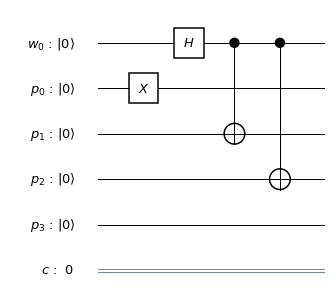

In [4]:
p = QuantumRegister(4,"p")
w = QuantumRegister(1,"w")
c = ClassicalRegister(1, "c")
circuit = oneQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

Let us see what state we expect here. According to the general logic of the QPE circuit, we should be in the state
$$
\frac{1}{\sqrt{2}} \sum_{s=0}^1 |a^s \rangle |s \rangle  =\frac{1}{\sqrt{2}} (  |1 \rangle |0\rangle + 
|7\rangle) |1 \rangle  = \frac{1}{\sqrt{2}} ( |2 \rangle + 
|15\rangle) 
$$
Here we follow the Qiskit convention and write the primary register first, yielding the most significant bits. Let us test this using the state vector simulator.

In [5]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
job.result().get_statevector()

array([ 0.00000000+0.j,  0.00000000+0.j,  0.70710678+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.70710678+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j])

no measurements in circuit 'circuit8', classical register will remain all zeros.


Nice, this is what we expected. Let us now see how we can extend this to two qubits. For that purpose, we need to add a conditional version of $a^2$. As $a^2 = 49 = 4$ module 15, this gate needs to map $|x \rangle$ to $|4x \rangle$. However, it again suffices to implement this for the two possible inputs that can be outputs of the first gate, i.e. $|1 \rangle$ - being mapped to $|4 \rangle$ - and $|7\rangle$, being mapped to $|13 \rangle$. This is a conditional swap of p[2] with p[0] and p[3] with p[1]. Now in QASM a conditional swap can be implemented as follows.
```
gate cswap a,b,c
{
  cx c,b;
  ccx a,b,c;
  cx c,b;
}
```

In [6]:
def twoQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gates to working register
    circuit.h(w[0])
    circuit.h(w[1])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[2])
    # Add conditional swaps
    circuit.cx(p[0], p[2])
    circuit.ccx(w[1], p[2], p[0])
    circuit.cx(p[0], p[2])
    circuit.barrier(p)
    circuit.cx(p[3], p[1])
    circuit.ccx(w[1], p[1], p[3])
    circuit.cx(p[3], p[1])
    return circuit

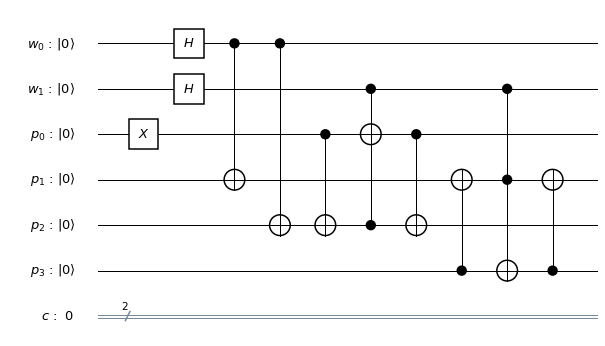

In [7]:
p = QuantumRegister(4,"p")
w = QuantumRegister(2,"w")
c = ClassicalRegister(2, "c")
circuit = twoQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

Let us again test this. We expect the following four basis vectors to show up
$$
|1\rangle |0 \rangle = |4\rangle
$$
$$
|7\rangle |1 \rangle = |29\rangle
$$
$$
|4\rangle |2 \rangle = |18\rangle
$$
$$
|13\rangle |3 \rangle = |55\rangle
$$


In [8]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
state = np.around(job.result().get_statevector(), 2)
for i in range(2**6):
    if (state[i] != 0):
        print("|",i,"> ---> ", state[i])

| 4 > --->  (0.5-0j)
| 18 > --->  (0.5-0j)
| 29 > --->  (0.5-0j)
| 55 > --->  (0.5-0j)


Finally, the last circuit we need is multiplication by $a^4$ modulo 15. But this is again one, so the circuit is the identity! Therefore our three qubit circuit is identical to our two qubit circuit, just with one more qubit in the working register. For this final version, let us also make a few simplications. The first conditional CNOT between p[0] and p[2] can be replaced by an X-gate as it will always act. Similarly, the CNOT between p[3] and p[1] can be dropped as its control qubit will always be zero.

In [9]:
def threeQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gates to working register
    circuit.h(w[0])
    circuit.h(w[1])
    circuit.h(w[2])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[2])
    # Add conditional swaps
    
    circuit.x(p[2])
    circuit.ccx(w[1], p[2], p[0])
    circuit.cx(p[0], p[2])
    
    circuit.barrier(p)
    circuit.ccx(w[1], p[1], p[3])
    circuit.cx(p[3], p[1])

    return circuit

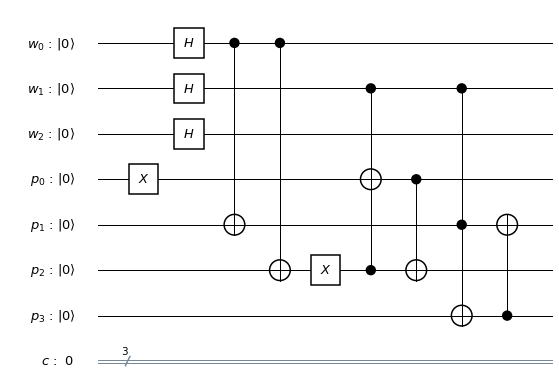

In [10]:
p = QuantumRegister(4,"p")
w = QuantumRegister(3,"w")
c = ClassicalRegister(3, "c")
circuit = threeQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

In [11]:
#
# Print out expected amplitudes up to normalisation
# 
for s in range(2**3):
    x = a**s % 15
    print("|", x*8 + s, "> = |",x,">|", s,">")

| 8 > = | 1 >| 0 >
| 57 > = | 7 >| 1 >
| 34 > = | 4 >| 2 >
| 107 > = | 13 >| 3 >
| 12 > = | 1 >| 4 >
| 61 > = | 7 >| 5 >
| 38 > = | 4 >| 6 >
| 111 > = | 13 >| 7 >


In [12]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
state = np.around(job.result().get_statevector(), 2)
for i in range(2**7):
    if (state[i] != 0):
        print("|",i,"> = |", i // 8, ">|", i % 8,"> ---> ", state[i])

| 8 > = | 1 >| 0 > --->  (0.35-0j)
| 12 > = | 1 >| 4 > --->  (0.35-0j)
| 34 > = | 4 >| 2 > --->  (0.35-0j)
| 38 > = | 4 >| 6 > --->  (0.35-0j)
| 57 > = | 7 >| 1 > --->  (0.35-0j)
| 61 > = | 7 >| 5 > --->  (0.35-0j)
| 107 > = | 13 >| 3 > --->  (0.35-0j)
| 111 > = | 13 >| 7 > --->  (0.35-0j)


So our circuit seems to work fine. Time to combine it with the QFT.

In [13]:
def nBitQFT(q,c,n=3):
    circuit = QuantumCircuit(q,c)
    #
    # We start with the most significant bit
    #
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        circuit.h(q[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),q[i], q[j-1])
    #
    # Finally we need to swap qubits
    #
    for i in range(n//2):
        circuit.swap(q[i], q[n-i-1])
    return circuit

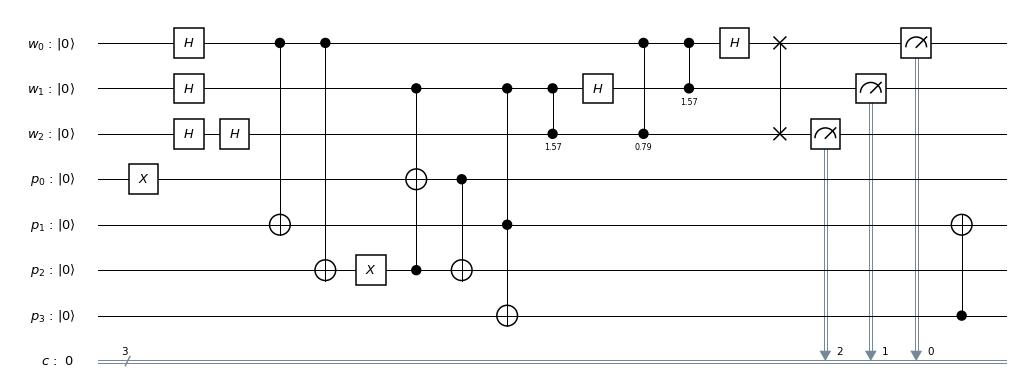

In [14]:
circuit = threeQbitCircuit(p,w,c) + nBitQFT(w,c,n=3)
circuit.barrier(w)
circuit.measure(w,c)
drawer(circuit, style=my_style)

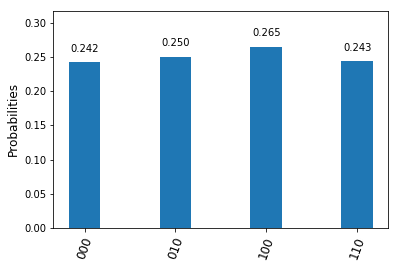

In [15]:
backend = Aer.get_backend('qasm_simulator') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)

Again, there are a few additional simplifications that we can make. Oon w[2], we have a double Hadamard that we can remove. We can again dispose of the final swap gates and do the swap in the measurement. The last CNOT between p[1] and p[3] can be dropped as it does not affect the outcome. The same is true for the last CNOT between p[0] and p[2].

In [35]:
def shorAlgorithm(n=3):
    # Create registers and circuit
    p = QuantumRegister(4,"p")
    w = QuantumRegister(n,"w")
    c = ClassicalRegister(n, "c")
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gates to working register
    circuit.h(w[0])
    circuit.h(w[1])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[2])
    # Add conditional swaps
    
    circuit.x(p[2])
    circuit.ccx(w[1], p[2], p[0])
    #circuit.cx(p[0], p[2])
    
    circuit.barrier(p)
    circuit.ccx(w[1], p[1], p[3])
    
    # The QFT part
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        if (j -  1) !=2:
            circuit.h(w[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),w[i], w[j-1])
   
    #
    # and measure
    #
    circuit.barrier(w)
    circuit.measure(w[0],c[2])
    circuit.measure(w[1],c[1])
    circuit.measure(w[2],c[0])
    return circuit

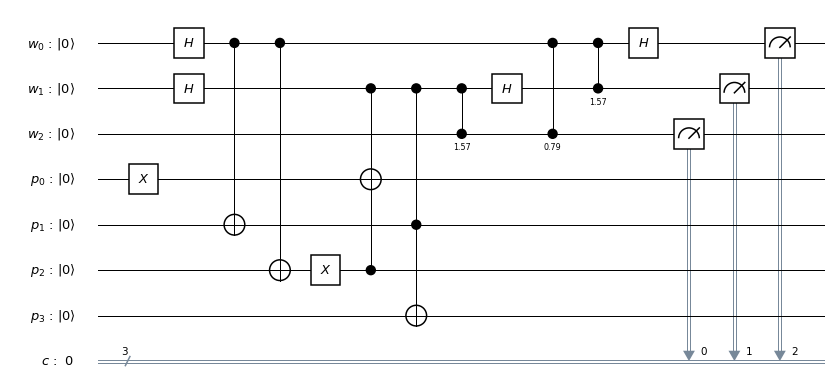

In [36]:
circuit = shorAlgorithm()
drawer(circuit, style=my_style)

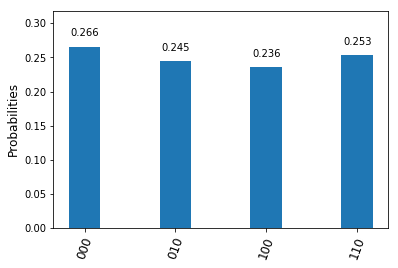

In [37]:
backend = Aer.get_backend('qasm_simulator') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)

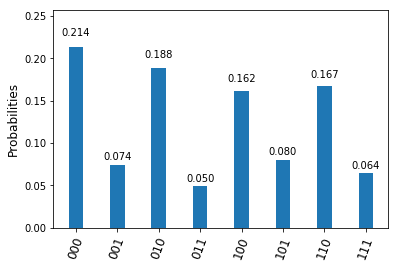

In [38]:
IBMQ.load_accounts()
backend = IBMQ.get_backend('ibmq_16_melbourne') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)

In [39]:
counts

{'000': 219,
 '001': 76,
 '010': 193,
 '011': 51,
 '100': 166,
 '101': 82,
 '110': 171,
 '111': 66}